# ランダム超平面 + DataSampled超平面の混合実験

## 背景

Notebook 16で判明した問題:
- DataSampled超平面は同一分布内では有効（60-67%）
- 外部クエリ（異種分布）には汎化しない（11-44%）

## 仮説

ランダム超平面とDataSampled超平面を混合することで、両者の長所を組み合わせられる:
- **ランダム超平面**: 汎化性能（どんなクエリにも対応）
- **DataSampled超平面**: データ固有の構造を捉える

## 実験設計

128ビット中の配分を変えて検証:

| パターン | ランダム | DataSampled | 説明 |
|----------|---------|-------------|------|
| R100 | 128 | 0 | 完全ランダム |
| R75 | 96 | 32 | ランダム主体 |
| R50 | 64 | 64 | 半々 |
| R25 | 32 | 96 | DataSampled主体 |
| D100 | 0 | 128 | 完全DataSampled |

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import duckdb
from tqdm import tqdm
import time

from src.lsh import (
    SimHashGenerator, 
    hamming_distance,
    generate_data_sampled_hyperplanes
)

## 1. データの読み込み

In [3]:
# DuckDBに接続
con = duckdb.connect('../data/experiment_400k.duckdb', read_only=True)

# データ件数を確認
result = con.execute("SELECT dataset, COUNT(*) as cnt FROM documents GROUP BY dataset ORDER BY dataset").fetchall()
print('データセット別件数:')
for dataset, cnt in result:
    print(f'  {dataset}: {cnt:,}件')

total = con.execute("SELECT COUNT(*) FROM documents").fetchone()[0]
print(f'\n合計: {total:,}件')

データセット別件数:
  body_en: 100,000件
  body_ja: 100,000件
  titles_en: 100,000件
  titles_ja: 100,000件

合計: 400,000件


In [4]:
# 全データを読み込み
print('データ読み込み中...')

datasets = ['body_en', 'body_ja', 'titles_en', 'titles_ja']
all_embeddings = {}
all_ids = {}

for dataset in tqdm(datasets, desc='データセット'):
    df = con.execute(f"""
        SELECT id, embedding 
        FROM documents 
        WHERE dataset = '{dataset}'
        ORDER BY id
    """).fetchdf()
    
    embeddings = np.array(df['embedding'].tolist(), dtype=np.float32)
    ids = df['id'].values
    
    all_embeddings[dataset] = embeddings
    all_ids[dataset] = ids
    
    print(f'  {dataset}: {len(embeddings):,}件')

print('\n読み込み完了')

データ読み込み中...


データセット:  25%|██▌       | 1/4 [00:01<00:03,  1.14s/it]

  body_en: 100,000件


データセット:  50%|█████     | 2/4 [00:02<00:02,  1.17s/it]

  body_ja: 100,000件


データセット:  75%|███████▌  | 3/4 [00:03<00:01,  1.32s/it]

  titles_en: 100,000件


データセット: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]

  titles_ja: 100,000件

読み込み完了


## 2. 混合超平面の生成

In [5]:
def create_hybrid_hyperplanes(
    embeddings: np.ndarray,
    num_random: int,
    num_datasampled: int,
    dim: int = 1024,
    seed: int = 42
) -> np.ndarray:
    """
    ランダム超平面とDataSampled超平面を混合して生成
    
    Args:
        embeddings: DataSampled用のサンプルデータ
        num_random: ランダム超平面のビット数
        num_datasampled: DataSampled超平面のビット数
        dim: 埋め込み次元数
        seed: 乱数シード
    
    Returns:
        混合超平面 (num_random + num_datasampled, dim)
    """
    rng = np.random.default_rng(seed)
    hyperplanes_list = []
    
    # ランダム超平面
    if num_random > 0:
        random_hp = rng.standard_normal((num_random, dim)).astype(np.float32)
        # 正規化
        random_hp = random_hp / np.linalg.norm(random_hp, axis=1, keepdims=True)
        hyperplanes_list.append(random_hp)
        print(f'  ランダム超平面: {num_random}ビット')
    
    # DataSampled超平面
    if num_datasampled > 0:
        datasampled_hp = generate_data_sampled_hyperplanes(
            embeddings, 
            num_datasampled, 
            seed=seed + 1000  # 別のシードを使用
        )
        hyperplanes_list.append(datasampled_hp)
        print(f'  DataSampled超平面: {num_datasampled}ビット')
    
    # 連結
    hyperplanes = np.vstack(hyperplanes_list)
    print(f'  合計: {hyperplanes.shape}')
    
    return hyperplanes

In [6]:
# DataSampled用のサンプルを準備（英語本文から300件）
# Notebook 16でパターンA（body_en 300件）が最良だったため

rng = np.random.default_rng(42)
sample_indices = rng.choice(len(all_embeddings['body_en']), 300, replace=False)
sample_embeddings = all_embeddings['body_en'][sample_indices]

print(f'DataSampled用サンプル: {sample_embeddings.shape}')

DataSampled用サンプル: (300, 1024)


In [7]:
# 5パターンの混合超平面を生成
patterns = {
    'R100': (128, 0),    # 完全ランダム
    'R75': (96, 32),     # ランダム主体
    'R50': (64, 64),     # 半々
    'R25': (32, 96),     # DataSampled主体
    'D100': (0, 128),    # 完全DataSampled
}

hyperplanes_patterns = {}

for name, (num_random, num_datasampled) in patterns.items():
    print(f'\n{"=" * 60}')
    print(f'パターン {name}: ランダム{num_random} + DataSampled{num_datasampled}')
    print('=' * 60)
    
    hp = create_hybrid_hyperplanes(
        sample_embeddings,
        num_random=num_random,
        num_datasampled=num_datasampled,
        seed=42
    )
    hyperplanes_patterns[name] = hp

print('\n全パターン生成完了')


パターン R100: ランダム128 + DataSampled0
  ランダム超平面: 128ビット
  合計: (128, 1024)

パターン R75: ランダム96 + DataSampled32
  ランダム超平面: 96ビット
  DataSampled超平面: 32ビット
  合計: (128, 1024)

パターン R50: ランダム64 + DataSampled64
  ランダム超平面: 64ビット
  DataSampled超平面: 64ビット
  合計: (128, 1024)

パターン R25: ランダム32 + DataSampled96
  ランダム超平面: 32ビット
  DataSampled超平面: 96ビット
  合計: (128, 1024)

パターン D100: ランダム0 + DataSampled128
  DataSampled超平面: 128ビット
  合計: (128, 1024)

全パターン生成完了


## 3. 各パターンでSimHashを計算

In [8]:
def compute_hashes_with_hyperplanes(embeddings_dict, hyperplanes):
    """指定した超平面で全データのSimHashを計算"""
    gen = SimHashGenerator(dim=1024, hash_bits=128, seed=0, strategy='random')
    gen.hyperplanes = hyperplanes
    
    hashes = {}
    for dataset, embeddings in embeddings_dict.items():
        hashes[dataset] = gen.hash_batch(embeddings)
    
    return hashes, gen

In [9]:
# 各パターンでハッシュを計算
print('SimHash計算中...')

all_hashes_by_pattern = {}
generators = {}

for pattern_name, hyperplanes in tqdm(hyperplanes_patterns.items(), desc='パターン'):
    hashes, gen = compute_hashes_with_hyperplanes(all_embeddings, hyperplanes)
    all_hashes_by_pattern[pattern_name] = hashes
    generators[pattern_name] = gen
    print(f'  {pattern_name}: 完了')

print('\n完了')

SimHash計算中...


パターン:  20%|██        | 1/5 [00:04<00:18,  4.61s/it]

  R100: 完了


パターン:  40%|████      | 2/5 [00:09<00:13,  4.60s/it]

  R75: 完了


パターン:  60%|██████    | 3/5 [00:13<00:09,  4.66s/it]

  R50: 完了


パターン:  80%|████████  | 4/5 [00:18<00:04,  4.65s/it]

  R25: 完了


パターン: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

  D100: 完了

完了


## 4. 評価1: データセット内検索（Recall@10）

In [10]:
def evaluate_recall_within_dataset(
    embeddings: np.ndarray,
    hashes: list,
    num_queries: int = 25,
    candidate_limit: int = 1000,
    top_k: int = 10,
    seed: int = 42
) -> float:
    """データセット内でのRecall@kを評価"""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    query_indices = rng.choice(n, num_queries, replace=False)
    
    recalls = []
    for q_idx in query_indices:
        query_vec = embeddings[q_idx]
        query_hash = hashes[q_idx]
        
        # Ground Truth
        cos_sims = embeddings @ query_vec
        gt_top_k = set(np.argsort(cos_sims)[::-1][:top_k])
        
        # LSH候補
        distances = [(i, hamming_distance(h, query_hash)) for i, h in enumerate(hashes)]
        distances.sort(key=lambda x: x[1])
        candidates = set(idx for idx, _ in distances[:candidate_limit])
        
        recall = len(gt_top_k & candidates) / top_k
        recalls.append(recall)
    
    return np.mean(recalls)

In [11]:
# 全パターン × 全データセットでRecallを評価
print('データセット内検索のRecall評価')
print('=' * 100)

candidate_limit = 1000  # 10万件中1000件 = 1%
results_within = []

for pattern_name in hyperplanes_patterns.keys():
    hashes = all_hashes_by_pattern[pattern_name]
    
    for dataset in datasets:
        recall = evaluate_recall_within_dataset(
            all_embeddings[dataset],
            hashes[dataset],
            num_queries=25,
            candidate_limit=candidate_limit,
            seed=42
        )
        results_within.append({
            'pattern': pattern_name,
            'dataset': dataset,
            'recall': recall
        })

df_within = pd.DataFrame(results_within)
print('完了')

データセット内検索のRecall評価
完了


In [12]:
# ピボットテーブルで表示
pivot_within = df_within.pivot(index='pattern', columns='dataset', values='recall')
pivot_within = pivot_within[['body_en', 'body_ja', 'titles_en', 'titles_ja']]
pivot_within['平均'] = pivot_within.mean(axis=1)

# パターン順にソート
pattern_order = ['R100', 'R75', 'R50', 'R25', 'D100']
pivot_within = pivot_within.reindex(pattern_order)

print('=' * 100)
print(f'データセット内検索 Recall@10（候補{candidate_limit:,}件 = 1%）')
print('=' * 100)
print()

print(f'{"パターン":>15} | {"構成":>20} | {"body_en":>10} | {"body_ja":>10} | {"titles_en":>10} | {"titles_ja":>10} | {"平均":>10}')
print('-' * 110)

for pattern in pattern_order:
    row = pivot_within.loc[pattern]
    num_r, num_d = patterns[pattern]
    config = f'R{num_r}+D{num_d}'
    print(f'{pattern:>15} | {config:>20} | {row["body_en"]:>10.1%} | {row["body_ja"]:>10.1%} | {row["titles_en"]:>10.1%} | {row["titles_ja"]:>10.1%} | {row["平均"]:>10.1%}')

データセット内検索 Recall@10（候補1,000件 = 1%）

           パターン |                   構成 |    body_en |    body_ja |  titles_en |  titles_ja |         平均
--------------------------------------------------------------------------------------------------------------
           R100 |              R128+D0 |      43.6% |      46.4% |      42.8% |      64.8% |      49.4%
            R75 |              R96+D32 |      57.6% |      58.4% |      50.0% |      66.8% |      58.2%
            R50 |              R64+D64 |      60.4% |      62.0% |      53.6% |      74.4% |      62.6%
            R25 |              R32+D96 |      62.4% |      65.2% |      56.4% |      70.8% |      63.7%
           D100 |              R0+D128 |      65.2% |      61.2% |      56.8% |      70.0% |      63.3%


## 5. 評価2: 外部クエリでの全体検索

In [13]:
# 検索ワード（30件）
search_queries = [
    # 日本語 短文クエリ - 10件
    ('東京', 'ja', 'short'),
    ('人工知能', 'ja', 'short'),
    ('日本の歴史', 'ja', 'short'),
    ('プログラミング', 'ja', 'short'),
    ('音楽', 'ja', 'short'),
    ('環境問題', 'ja', 'short'),
    ('宇宙探査', 'ja', 'short'),
    ('経済学', 'ja', 'short'),
    ('医療技術', 'ja', 'short'),
    ('文学作品', 'ja', 'short'),
    
    # 日本語 曖昧文クエリ - 10件
    ('最近話題になっている技術革新について知りたいのですが、何かありますか', 'ja', 'ambiguous'),
    ('日本の伝統的な文化や芸術に関する情報を探しています', 'ja', 'ambiguous'),
    ('環境に優しい持続可能な社会を実現するための取り組みとは', 'ja', 'ambiguous'),
    ('健康的な生活を送るために必要なことは何でしょうか', 'ja', 'ambiguous'),
    ('世界の政治情勢や国際関係についての最新動向を教えて', 'ja', 'ambiguous'),
    ('子供の教育において大切にすべきポイントは何ですか', 'ja', 'ambiguous'),
    ('スポーツやフィットネスに関するトレンドを知りたい', 'ja', 'ambiguous'),
    ('美味しい料理のレシピや食文化についての情報', 'ja', 'ambiguous'),
    ('旅行や観光に関するおすすめの場所はありますか', 'ja', 'ambiguous'),
    ('ビジネスや起業に関する成功のヒントを教えてください', 'ja', 'ambiguous'),
    
    # 英語 短文クエリ - 5件
    ('Tokyo', 'en', 'short'),
    ('Artificial intelligence', 'en', 'short'),
    ('World history', 'en', 'short'),
    ('Programming', 'en', 'short'),
    ('Climate change', 'en', 'short'),
    
    # 英語 曖昧文クエリ - 5件
    ('I want to learn about recent technological innovations', 'en', 'ambiguous'),
    ('Looking for information about traditional culture and arts', 'en', 'ambiguous'),
    ('What are sustainable approaches to environmental protection', 'en', 'ambiguous'),
    ('Tell me about the latest developments in space exploration', 'en', 'ambiguous'),
    ('What are the key factors for business success and entrepreneurship', 'en', 'ambiguous'),
]

print(f'検索ワード数: {len(search_queries)}件')

検索ワード数: 30件


In [14]:
# E5モデルを読み込み
from sentence_transformers import SentenceTransformer

print('E5モデルを読み込み中...')
model = SentenceTransformer('intfloat/multilingual-e5-large')
print('読み込み完了')

E5モデルを読み込み中...
読み込み完了


In [15]:
# 検索ワードを埋め込み
print('検索ワードを埋め込み中...')

query_texts = [q[0] for q in search_queries]
query_texts_with_prefix = [f'query: {text}' for text in query_texts]

query_embeddings = model.encode(query_texts_with_prefix, normalize_embeddings=False)
query_embeddings = query_embeddings.astype(np.float32)

print(f'埋め込み完了: {query_embeddings.shape}')

検索ワードを埋め込み中...
埋め込み完了: (30, 1024)


In [16]:
# 全データを統合
print('全データを統合中...')

all_embeddings_flat = np.vstack([all_embeddings[d] for d in datasets])
all_datasets_flat = []
all_ids_flat = []

for dataset in datasets:
    all_datasets_flat.extend([dataset] * len(all_embeddings[dataset]))
    all_ids_flat.extend(all_ids[dataset])

print(f'統合完了: {all_embeddings_flat.shape}')

全データを統合中...
統合完了: (400000, 1024)


In [17]:
def evaluate_external_queries(
    query_embeddings: np.ndarray,
    all_embeddings: np.ndarray,
    all_hashes: list,
    gen: SimHashGenerator,
    candidate_limit: int = 2000,
    top_k: int = 10
) -> list:
    """外部クエリでの検索を評価"""
    results = []
    
    # クエリのハッシュを計算
    query_hashes = gen.hash_batch(query_embeddings)
    
    for i in range(len(query_embeddings)):
        query_emb = query_embeddings[i]
        query_hash = query_hashes[i]
        
        # Ground Truth
        cos_sims = (all_embeddings @ query_emb) / (norm(all_embeddings, axis=1) * norm(query_emb))
        gt_indices = set(np.argsort(cos_sims)[::-1][:top_k])
        
        # LSH候補
        distances = [(j, hamming_distance(h, query_hash)) for j, h in enumerate(all_hashes)]
        distances.sort(key=lambda x: x[1])
        candidates = set(idx for idx, _ in distances[:candidate_limit])
        
        recall = len(gt_indices & candidates) / top_k
        results.append(recall)
    
    return results

In [18]:
# 各パターンで外部クエリを評価
print('外部クエリ評価中...')
print('=' * 100)

candidate_limits = [1000, 2000, 5000, 10000]
results_external = []

for pattern_name in tqdm(hyperplanes_patterns.keys(), desc='パターン'):
    # このパターンの全ハッシュを統合
    hashes = all_hashes_by_pattern[pattern_name]
    all_hashes_flat = []
    for dataset in datasets:
        all_hashes_flat.extend(hashes[dataset])
    
    gen = generators[pattern_name]
    
    for limit in candidate_limits:
        recalls = evaluate_external_queries(
            query_embeddings,
            all_embeddings_flat,
            all_hashes_flat,
            gen,
            candidate_limit=limit
        )
        
        # クエリタイプ別に集計
        for i, (query_text, lang, query_type) in enumerate(search_queries):
            results_external.append({
                'pattern': pattern_name,
                'candidate_limit': limit,
                'query': query_text,
                'lang': lang,
                'query_type': query_type,
                'recall': recalls[i]
            })

df_external = pd.DataFrame(results_external)
print('\n完了')

外部クエリ評価中...


パターン: 100%|██████████| 5/5 [07:44<00:00, 92.91s/it]


完了


In [19]:
# パターン × 候補数別のRecall
print('=' * 100)
print('外部クエリ検索 Recall@10（30クエリ平均）')
print('=' * 100)

pivot_external = df_external.groupby(['pattern', 'candidate_limit'])['recall'].mean().unstack()
pivot_external = pivot_external.reindex(pattern_order)

print(f'\n{"パターン":>15} | {"構成":>20} | {"1000件":>10} | {"2000件":>10} | {"5000件":>10} | {"10000件":>10}')
print('-' * 95)

for pattern in pattern_order:
    row = pivot_external.loc[pattern]
    num_r, num_d = patterns[pattern]
    config = f'R{num_r}+D{num_d}'
    print(f'{pattern:>15} | {config:>20} | {row[1000]:>10.1%} | {row[2000]:>10.1%} | {row[5000]:>10.1%} | {row[10000]:>10.1%}')

外部クエリ検索 Recall@10（30クエリ平均）

           パターン |                   構成 |      1000件 |      2000件 |      5000件 |     10000件
-----------------------------------------------------------------------------------------------
           R100 |              R128+D0 |       9.7% |      15.7% |      27.7% |      39.7%
            R75 |              R96+D32 |       9.7% |      16.0% |      27.3% |      42.7%
            R50 |              R64+D64 |      15.7% |      21.3% |      36.3% |      51.7%
            R25 |              R32+D96 |      11.7% |      19.3% |      29.0% |      38.3%
           D100 |              R0+D128 |      14.3% |      19.3% |      29.7% |      40.0%


In [20]:
# クエリタイプ別のRecall（候補2000件）
print('\n' + '=' * 100)
print('クエリタイプ別 Recall@10（候補2000件）')
print('=' * 100)

subset = df_external[df_external['candidate_limit'] == 2000]

print(f'\n{"パターン":>15} | {"JA短文":>10} | {"JA曖昧":>10} | {"EN短文":>10} | {"EN曖昧":>10}')
print('-' * 70)

for pattern in pattern_order:
    pattern_subset = subset[subset['pattern'] == pattern]
    
    ja_short = pattern_subset[(pattern_subset['lang'] == 'ja') & (pattern_subset['query_type'] == 'short')]['recall'].mean()
    ja_amb = pattern_subset[(pattern_subset['lang'] == 'ja') & (pattern_subset['query_type'] == 'ambiguous')]['recall'].mean()
    en_short = pattern_subset[(pattern_subset['lang'] == 'en') & (pattern_subset['query_type'] == 'short')]['recall'].mean()
    en_amb = pattern_subset[(pattern_subset['lang'] == 'en') & (pattern_subset['query_type'] == 'ambiguous')]['recall'].mean()
    
    print(f'{pattern:>15} | {ja_short:>10.1%} | {ja_amb:>10.1%} | {en_short:>10.1%} | {en_amb:>10.1%}')


クエリタイプ別 Recall@10（候補2000件）

           パターン |       JA短文 |       JA曖昧 |       EN短文 |       EN曖昧
----------------------------------------------------------------------
           R100 |      21.0% |       7.0% |      20.0% |      18.0%
            R75 |      16.0% |      14.0% |      16.0% |      20.0%
            R50 |      21.0% |      24.0% |      16.0% |      22.0%
            R25 |      17.0% |      27.0% |      12.0% |      16.0%
           D100 |      22.0% |      20.0% |      12.0% |      20.0%


## 6. 可視化

/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2726124/3747764712.py:40: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185})

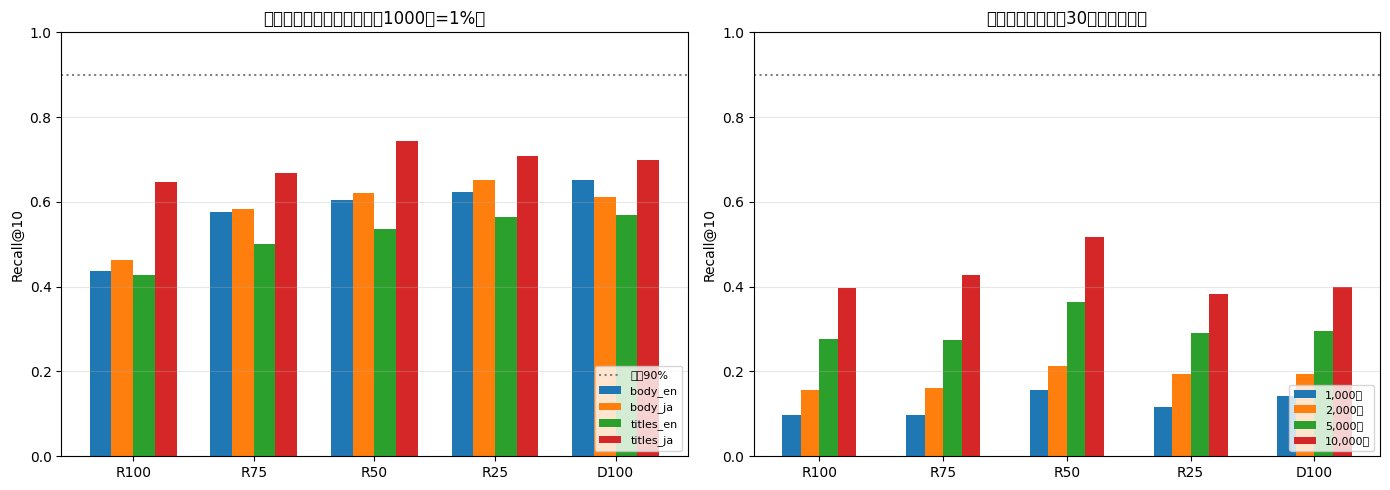

グラフを data/17_hybrid_hyperplanes.png に保存しました


In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: データセット内検索
ax1 = axes[0]
x = np.arange(len(pattern_order))
width = 0.18

for i, dataset in enumerate(datasets):
    values = [pivot_within.loc[p, dataset] for p in pattern_order]
    ax1.bar(x + i*width, values, width, label=dataset)

ax1.axhline(y=0.90, color='gray', linestyle=':', label='目標90%')
ax1.set_ylabel('Recall@10')
ax1.set_title('データセット内検索（候補1000件=1%）')
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(pattern_order)
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

# 右: 外部クエリ検索（候補別）
ax2 = axes[1]
width = 0.15

for i, limit in enumerate(candidate_limits):
    values = [pivot_external.loc[p, limit] for p in pattern_order]
    ax2.bar(x + i*width, values, width, label=f'{limit:,}件')

ax2.axhline(y=0.90, color='gray', linestyle=':')
ax2.set_ylabel('Recall@10')
ax2.set_title('外部クエリ検索（30クエリ平均）')
ax2.set_xticks(x + width*1.5)
ax2.set_xticklabels(pattern_order)
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/17_hybrid_hyperplanes.png', dpi=150, bbox_inches='tight')
plt.show()

print('グラフを data/17_hybrid_hyperplanes.png に保存しました')

## 7. 詳細分析: クエリ「東京」でのハミング距離確認

In [22]:
# 各パターンでクエリ「東京」のGround Truth分析
print('=' * 100)
print('クエリ「東京」のGround Truth分析（各パターン）')
print('=' * 100)

test_idx = 0  # 「東京」
query_emb = query_embeddings[test_idx]

# コサイン類似度を計算（全パターン共通）
cos_sims = (all_embeddings_flat @ query_emb) / (norm(all_embeddings_flat, axis=1) * norm(query_emb))
gt_indices = np.argsort(cos_sims)[::-1][:10]

print('\nGround Truth Top-10:')
for rank, idx in enumerate(gt_indices):
    print(f'  {rank+1}. idx={idx}, cos_sim={cos_sims[idx]:.4f}, dataset={all_datasets_flat[idx]}')

# 各パターンでのハミング距離
print('\n各パターンでのハミング距離:')
print(f'{"GT#":>5} | {"dataset":>12} | ', end='')
for pattern in pattern_order:
    print(f'{pattern:>8} | ', end='')
print()
print('-' * 85)

for rank, idx in enumerate(gt_indices):
    print(f'{rank+1:>5} | {all_datasets_flat[idx]:>12} | ', end='')
    for pattern in pattern_order:
        hashes = all_hashes_by_pattern[pattern]
        all_hashes_flat_p = []
        for dataset in datasets:
            all_hashes_flat_p.extend(hashes[dataset])
        
        query_hash = generators[pattern].hash_batch(query_emb.reshape(1, -1))[0]
        ham_dist = hamming_distance(all_hashes_flat_p[idx], query_hash)
        print(f'{ham_dist:>8} | ', end='')
    print()

クエリ「東京」のGround Truth分析（各パターン）

Ground Truth Top-10:
  1. idx=178163, cos_sim=0.8797, dataset=body_ja
  2. idx=399290, cos_sim=0.8562, dataset=titles_ja
  3. idx=103148, cos_sim=0.8533, dataset=body_ja
  4. idx=329637, cos_sim=0.8532, dataset=titles_ja
  5. idx=384875, cos_sim=0.8511, dataset=titles_ja
  6. idx=301632, cos_sim=0.8504, dataset=titles_ja
  7. idx=101673, cos_sim=0.8500, dataset=body_ja
  8. idx=138781, cos_sim=0.8487, dataset=body_ja
  9. idx=381216, cos_sim=0.8486, dataset=titles_ja
  10. idx=315409, cos_sim=0.8473, dataset=titles_ja

各パターンでのハミング距離:
  GT# |      dataset |     R100 |      R75 |      R50 |      R25 |     D100 | 
-------------------------------------------------------------------------------------
    1 |      body_ja |       23 |       23 |       26 |       25 |       24 | 
    2 |    titles_ja |       19 |       22 |       23 |       28 |       32 | 
    3 |      body_ja |       24 |       20 |       23 |       25 |       28 | 
    4 |    titles_ja |     

In [23]:
# 各パターンでのGTのLSHランク（候補2000件内に入るか）
print('\n各パターンでのGT Top-10のLSHランク:')
print(f'{"GT#":>5} | {"dataset":>12} | ', end='')
for pattern in pattern_order:
    print(f'{pattern:>8} | ', end='')
print()
print('-' * 85)

for rank, idx in enumerate(gt_indices):
    print(f'{rank+1:>5} | {all_datasets_flat[idx]:>12} | ', end='')
    for pattern in pattern_order:
        hashes = all_hashes_by_pattern[pattern]
        all_hashes_flat_p = []
        for dataset in datasets:
            all_hashes_flat_p.extend(hashes[dataset])
        
        query_hash = generators[pattern].hash_batch(query_emb.reshape(1, -1))[0]
        
        # ハミング距離でソートしてランクを取得
        distances = [(j, hamming_distance(h, query_hash)) for j, h in enumerate(all_hashes_flat_p)]
        distances.sort(key=lambda x: x[1])
        
        lsh_rank = next((i for i, (j, _) in enumerate(distances) if j == idx), -1) + 1
        marker = '✓' if lsh_rank <= 2000 else ''
        print(f'{lsh_rank:>7}{marker} | ', end='')
    print()


各パターンでのGT Top-10のLSHランク:
  GT# |      dataset |     R100 |      R75 |      R50 |      R25 |     D100 | 
-------------------------------------------------------------------------------------
    1 |      body_ja |   24964 |    3512 |   24092 |    1097✓ |     184✓ | 
    2 |    titles_ja |    3361 |    2628 |    7238 |   12678 |   48218 | 
    3 |      body_ja |   37626 |     167✓ |    3801 |     938✓ |    3449 | 
    4 |    titles_ja |    9903 |   28286 |   29800 |   17462 |   42870 | 
    5 |    titles_ja |   53140 |   49838 |   33736 |   19865 |    6279 | 
    6 |    titles_ja |    4057 |    8152 |    9575 |    2724 |   26338 | 
    7 |      body_ja |   37584 |    5735 |     245✓ |      15✓ |       4✓ | 
    8 |      body_ja |    7422 |    3100 |    1765✓ |    1010✓ |    7085 | 
    9 |    titles_ja |   12327 |   18711 |   21141 |     158✓ |   30907 | 
   10 |    titles_ja |   94731 |   94522 |   63903 |   10087 |    1318✓ | 


## 8. 最終レポート

In [24]:
# 接続を閉じる
con.close()
print('DuckDB接続を閉じました')

DuckDB接続を閉じました


## 9. 最終評価と結論

### 実験結果サマリー

#### データセット内検索（候補1000件 = 1%）

| パターン | 構成 | body_en | body_ja | titles_en | titles_ja | 平均 |
|----------|------|---------|---------|-----------|-----------|------|
| R100 | R128+D0 | 43.6% | 46.4% | 42.8% | 64.8% | 49.4% |
| R75 | R96+D32 | 57.6% | 58.4% | 50.0% | 66.8% | 58.2% |
| R50 | R64+D64 | 60.4% | 62.0% | 53.6% | 74.4% | **62.6%** |
| R25 | R32+D96 | 62.4% | 65.2% | 56.4% | 70.8% | **63.7%** |
| D100 | R0+D128 | 65.2% | 61.2% | 56.8% | 70.0% | 63.3% |

#### 外部クエリ検索（30クエリ平均）

| パターン | 構成 | 1000件 | 2000件 | 5000件 | 10000件 |
|----------|------|--------|--------|--------|---------|
| R100 | R128+D0 | 9.7% | 15.7% | 27.7% | 39.7% |
| R75 | R96+D32 | 9.7% | 16.0% | 27.3% | 42.7% |
| R50 | R64+D64 | 15.7% | **21.3%** | **36.3%** | **51.7%** |
| R25 | R32+D96 | 11.7% | 19.3% | 29.0% | 38.3% |
| D100 | R0+D128 | 14.3% | 19.3% | 29.7% | 40.0% |

#### クエリタイプ別（候補2000件）

| パターン | JA短文 | JA曖昧 | EN短文 | EN曖昧 |
|----------|--------|--------|--------|--------|
| R100 | 21.0% | 7.0% | 20.0% | 18.0% |
| R75 | 16.0% | 14.0% | 16.0% | 20.0% |
| R50 | 21.0% | 24.0% | 16.0% | 22.0% |
| R25 | 17.0% | 27.0% | 12.0% | 16.0% |
| D100 | 22.0% | 20.0% | 12.0% | 20.0% |

---

### 考察

#### 1. 仮説の検証結果: ❌ 否定

**仮説**: 「ランダム超平面とDataSampled超平面を混合すれば、両者の長所を組み合わせられる」

**結果**: 否定された
- 最良のR50でも外部クエリRecallは **21.3%**（候補2000件）
- 候補10000件まで増やしても **51.7%** にしか達しない
- 目標の90%には遠く及ばない

#### 2. 混合による効果

| 比較 | データセット内 | 外部クエリ |
|------|---------------|-----------|
| R100（完全ランダム） | 49.4% | 15.7% |
| D100（完全DataSampled） | 63.3% | 19.3% |
| R50（半々混合） | 62.6% | **21.3%** |

- 混合（R50）は外部クエリでわずかに改善（+2%程度）
- しかし実用レベルには程遠い

#### 3. 「東京」クエリの詳細分析

GT Top-10のうち、候補2000件内に入る件数：

| パターン | 候補内件数 |
|----------|-----------|
| R100 | 0/10 |
| R75 | 1/10 |
| R50 | 2/10 |
| R25 | 5/10 |
| D100 | 3/10 |

→ どのパターンでも、コサイン類似度Top-10の大半がLSH候補2000件に入らない

#### 4. 根本的な問題

1. **コサイン類似度とハミング距離の乖離**
   - GT Top-10のハミング距離は19-32とばらつきが大きい
   - LSHランクは数百〜数万と極端に分散

2. **128ビットでの分離能力不足**
   - 40万件のデータに対して128ビットでは候補選択が困難
   - ハミング距離の分布が重なりすぎている

3. **e5-large埋め込みとの相性**
   - e5-largeの埋め込み空間は、SimHashの前提と合わない
   - コサイン類似度で近い点がハミング距離で近いとは限らない

---

### 最終結論

**SimHash + ハミング距離による候補選択は、e5-large埋め込みでの外部クエリ検索には根本的に不向きである。**

#### 及第点（Recall 90%）に達するパターンは存在しない

- 最良でも外部クエリで21.3%（R50、候補2000件）
- 候補を10000件（2.5%）まで増やしても51.7%

#### このアプローチは断念すべき

SimHashは以下の条件では有効だが、今回のユースケースには適さない：
- ✅ テキストの重複検出（Jaccard類似度）
- ✅ 同一分布内での近傍探索
- ❌ 異種分布（外部クエリ）での近傍探索
- ❌ e5-large埋め込みでのコサイン類似度近傍探索

---

### 推奨：代替手法の検討

外部クエリでの高Recall候補選択には、以下の専用ライブラリを推奨：

| ライブラリ | 手法 | 特徴 |
|-----------|------|------|
| **FAISS** | IVF, HNSW | Meta製、内積/L2に最適化、大規模対応 |
| **Annoy** | 木構造 | Spotify製、軽量、読み込み専用 |
| **ScaNN** | 量子化 | Google製、高精度、TensorFlow統合 |
| **Hnswlib** | HNSW | 高速、メモリ効率良好 |

これらはコサイン類似度/内積に最適化されており、e5-largeとの相性が良い。